# Naive Bayes Classification

_Following a [GitHub notebook](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb) forming part of a lecture series by jakevd._

In this notebook, we take a look at a supervised learning algorithm, the **naive Bayes classification** method.

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets.
Because they are so fast and have so few tunable parameters, they end up being useful as a quick-and-dirty baseline for a classification problem.
This chapter will provide an intuitive explanation of how naive Bayes classifiers work, followed by a few examples of them in action on some datasets.

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship between conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label $L$ given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the **posterior (conditional)** probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is **some model by which we can compute $P({\rm features}~|~L_i)$ for each label**.
Such a model is called a **generative model** because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

In [53]:
#importing the necessary packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

C:\Users\franc\AppData\Local\Temp\ipykernel_12708\2472559512.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Gaussian Naive Bayes

Assume **data from each label is drawn from a simple Gaussian distribution**.
Imagine that we have the following data, shown in Fig. 1:

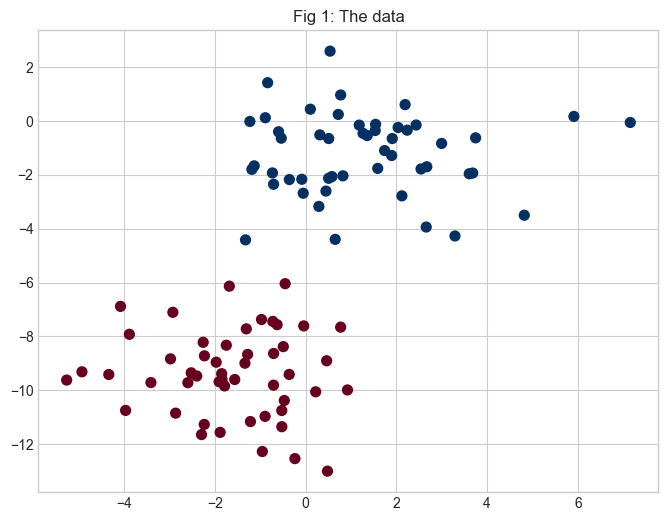

In [40]:
fig = plt.figure(figsize=(8,6))

X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');
plt.title('Fig 1: The data')
fig.savefig('Fig1_the_data.png')

The simplest Gaussian model is to assume that the data is described by a Gaussian distribution with **no covariance** between dimensions.
This model can be fit by computing the **mean** and **standard deviation** of the points within each label, which is all we need to define such a distribution.
The result of this naive Gaussian assumption is shown in the following figure:

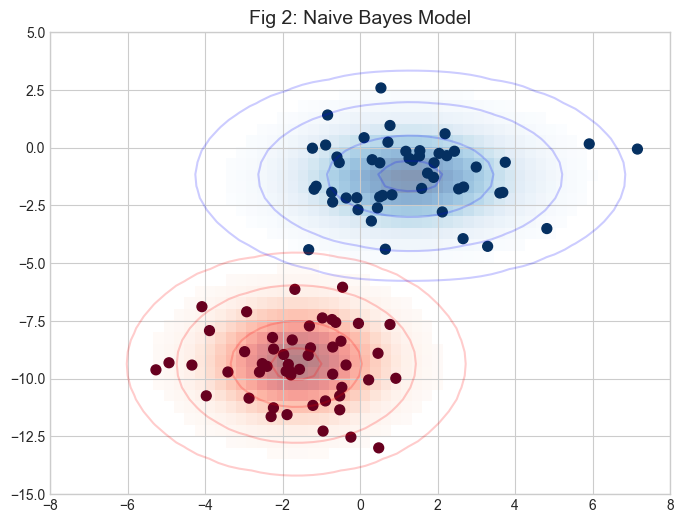

In [41]:
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Fig 2: Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

fig.savefig('Fig2_Naive_Gaussian.png')

The ellipses here represent the **Gaussian generative model** for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's `sklearn.naive_bayes.GaussianNB` estimator:

In [42]:
model = GaussianNB()
model.fit(X, y);

Let's generate some new data and predict the label:

In [43]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

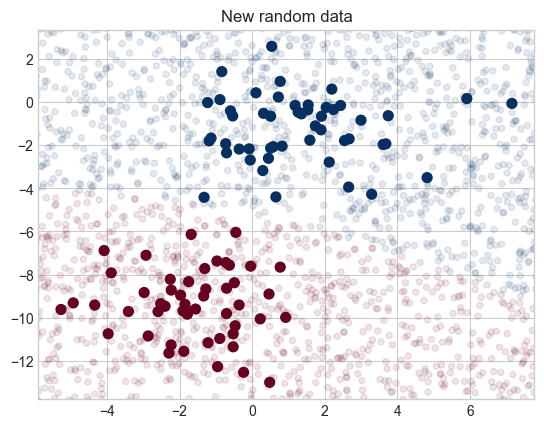

In [45]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);
plt.title('New random data')

fig.savefig('Fig3_New_data.png')

We see a slightly curved boundary in the classifications—in general, the **boundary produced by a Gaussian naive Bayes model will be quadratic.**

A nice aspect of this Bayesian formalism is that it naturally allows for **probabilistic classification**, which we can compute using the `predict_proba` method:

In [46]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

The columns give the **posterior (conditional) probabilities** of the first $(L_1)$ and second $(L_2)$ labels, respectively.
If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a good place to start.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results. Still, in many cases — especially as the number of features becomes large — this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a reliable method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.
The multinomial distribution describes the probability of observing counts among a number of categories, and thus **multinomial naive Bayes is most appropriate for features that represent counts or count rates.**

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model it with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
We discussed the extraction of such features from text in [Feature Engineering](05.04-Feature-Engineering.ipynb); here we will use the sparse word count features from the 20 Newsgroups corpus made available through Scikit-Learn to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [48]:
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories and download the training and testing sets:

In [49]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [50]:
print(train.data[5][48:])

Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to **convert the content of each string into a vector of numbers**.
For this we will use the TF-IDF vectorizer (introduced in [Feature Engineering](05.04-Feature-Engineering.ipynb)), and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [54]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can **apply the model to the training data and predict labels for the test data**:

In [55]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can **evaluate them to learn about the performance of the estimator**.
For example, let's take a look at the **confusion matrix** between the **true** and **predicted** labels for the test data (see the following figure):

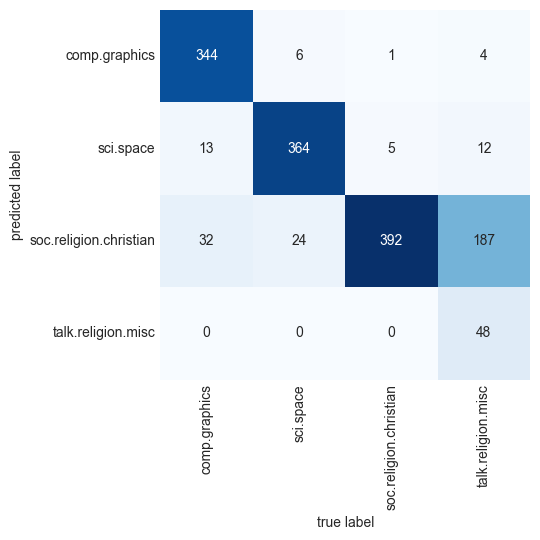

In [56]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names,
            cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space discussions from computer discussions, but it gets confused between discussions about religion and discussions about Christianity.
This is perhaps to be expected!

The cool thing here is that we now have the tools to determine the category for *any* string, using the `predict` method of this pipeline.
Here's a utility function that will return the prediction for a single string:

In [57]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [58]:
predict_category('sending a payload to the ISS')

'sci.space'

In [59]:
predict_category('discussing the existence of God')

'soc.religion.christian'

In [60]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## When to Use Naive Bayes

Because naive Bayes classifiers make such stringent assumptions about data, they will generally not perform as well as more complicated models.
That said, they have several advantages:

- They are fast for both training and prediction.
- They provide straightforward probabilistic prediction.
- They are often easily interpretable.
- They have few (if any) tunable parameters.

These advantages mean a naive Bayes classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimensionality of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like the ones discussed here tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

# Naive Bayes classification of exoplanet habitability


We will use previous data generated using LIFEsim in Tutorial 1, to predict planet habitability.

In [61]:
#import the necessary packages
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [62]:
df = pd.read_csv('LIFEsim_data.csv', index_col=0)

In [63]:
df

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,...,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
0,2.55899,1.21237,6.46922,0.0,0.36825,0.83082,4.28658,0.46104,0.07323,0.11134,...,0.745910,1.746354,1.246132,False,3.747645,21.85221,True,11.808785,35743.408285,0.0
1,1.62557,95.32925,2.94136,0.0,0.36825,4.71701,0.58424,3.76621,0.17084,0.46161,...,0.745910,1.746354,1.246132,False,2.570891,21.85221,True,8.100845,35743.408285,0.0
2,0.64641,413.44526,0.18259,0.0,0.36825,3.59078,0.90651,0.27668,0.54602,0.17279,...,0.745910,1.746354,1.246132,True,0.051327,21.85221,False,0.161731,35743.408285,0.0
3,1.45874,51.20469,5.36760,0.0,2.01016,2.62388,0.47298,2.25944,0.53153,0.47091,...,0.745910,1.746354,1.246132,False,8.482665,21.85221,True,26.728775,35743.408285,0.0
4,2.03712,98.57858,4.45356,0.0,2.01016,1.71757,2.04617,2.98199,0.32327,0.59087,...,0.745910,1.746354,1.246132,False,7.213424,21.85221,True,22.729412,35743.408285,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,0.82089,48.64809,3.00300,0.0,1.36699,3.29171,5.84907,1.15447,0.47915,0.40514,...,0.057153,0.151491,0.104322,True,0.286335,100.00000,False,0.000000,0.000000,-36000.0
14000,0.76631,3.78368,0.47407,0.0,2.15206,1.81751,2.27749,6.06507,0.36787,0.07721,...,0.057153,0.151491,0.104322,False,1.669327,100.00000,False,0.000000,0.000000,-36000.0
14001,1.29841,30.83798,1.36537,0.0,2.15206,5.07573,5.95634,4.86269,0.54785,0.21281,...,0.057153,0.151491,0.104322,True,0.552908,100.00000,False,0.000000,0.000000,-36000.0
14002,1.31487,184.70674,1.57873,0.0,2.15206,4.52980,5.85123,2.65320,0.54567,0.19618,...,0.057153,0.151491,0.104322,False,0.024031,100.00000,False,0.000000,0.000000,-36000.0


In [64]:
df.columns

Index(['radius_p', 'p_orb', 'mass_p', 'ecc_p', 'inc_p', 'large_omega_p',
       'small_omega_p', 'theta_p', 'albedo_bond', 'albedo_geom_vis',
       'albedo_geom_mir', 'z', 'semimajor_p', 'sep_p', 'angsep', 'maxangsep',
       'flux_p', 'fp', 'temp_p', 'radius_s', 'mass_s', 'temp_s', 'distance_s',
       'ra', 'dec', 'nuniverse', 'nstar', 'stype', 'id', 'name_s', 'lon',
       'lat', 's_in', 's_out', 'l_sun', 'hz_in', 'hz_out', 'hz_center',
       'habitable', 'snr_1h', 'baseline', 'detected', 'snr_current',
       'int_time', 't_slew'],
      dtype='object')

Let our binary classification be 'habitable' and 'unhabitable'. To use this data for machine learning, we need to convert 'habitable' and 'unhabitable' (and any other non-numerical columns) into numerical values.

In [65]:
#habitability=np.where(df['habitable']==True, 1, 0)
#df['habitability']=habitability

In [66]:
#convert the data type which is notfloat
notfloat=df.columns[(df.dtypes.values != np.dtype('float64'))]
for i in range(len(notfloat)):
    df[notfloat[i]] = df[notfloat[i]].astype('category').cat.codes
print(notfloat)

Index(['nuniverse', 'nstar', 'stype', 'id', 'habitable', 'detected'], dtype='object')


In [69]:
#also remove columns with NaN values
df=df.drop(columns='name_s')

nan_mask = df.isna()
print(nan_mask.sum())

radius_p           0
p_orb              0
mass_p             0
ecc_p              0
inc_p              0
large_omega_p      0
small_omega_p      0
theta_p            0
albedo_bond        0
albedo_geom_vis    0
albedo_geom_mir    0
z                  0
semimajor_p        0
sep_p              0
angsep             0
maxangsep          0
flux_p             0
fp                 0
temp_p             0
radius_s           0
mass_s             0
temp_s             0
distance_s         0
ra                 0
dec                0
nuniverse          0
nstar              0
stype              0
id                 0
lon                0
lat                0
s_in               0
s_out              0
l_sun              0
hz_in              0
hz_out             0
hz_center          0
habitable          0
snr_1h             0
baseline           0
detected           0
snr_current        0
int_time           0
t_slew             0
dtype: int64


In [70]:
habitable=df[ df['habitable'] == True]
print(len(habitable))
unhabitable = df[ df['habitable'] == False]
print(len(unhabitable))

1985
12019


In [71]:
cat=['Habitable', 'Unhabitable']
#print(cat)
cat_vals=[len(habitable), len(unhabitable)]
#print(cat_vals)

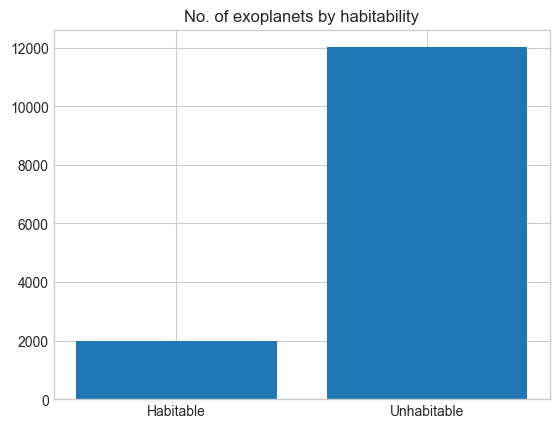

In [74]:
ax = plt.subplot(111)
ax.bar(cat, cat_vals, width=0.8, align='center')
ax.set_title('No. of exoplanets by habitability')

fig.savefig('Fig4_No_habitable.png')

We take the first half of the data as the training dataset and the second half as the test data.

In [77]:
#print(len(habitable)+ len(unhabitable))
#print(len(df))

In [78]:
training = df.loc[: len(df)/2-1]
test = df.loc[len(df)/2: ]

# output values to check df was split correctly
print(len(training),len(test), len(training)+len(test))
#print(training)
#print(test)

7002 7002 14004


Train the model on the `training` dataset, fitting using the 'habitable' property, and predict the habitability of the `test` data.

In [83]:
#train model
model=GaussianNB()
model.fit(training, training['habitable']);

In [84]:
#compare predictions to test data
predicted=model.predict(test)

Plot a confusion matrix to check correctness of predictions.

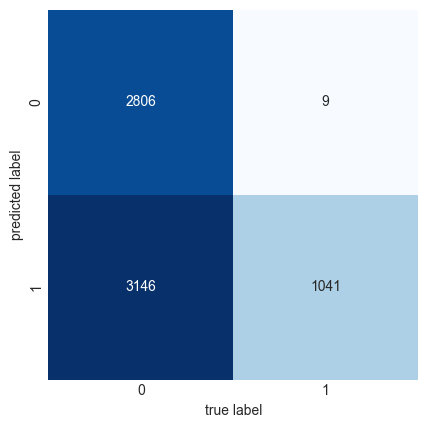

In [86]:
mat=confusion_matrix(test['habitable'], predicted)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

fig.savefig('Fig5_Confusion_matrix_1.png')

In [87]:
#print( mat[0,1], mat[1,0],  mat[0,0], mat[1,1])
print('Correct predictions: ', mat[0,0]+mat[1,1])
print('Incorrect predictions: ', mat[0,1]+mat[1,0])

Correct predictions:  3847
Incorrect predictions:  3155


As evident from the confusion matrix above, the model has trouble recognizing planets which are not habitable correctly, often classifying them as habitable. The reasons for this could be that there was not enough training data to make correct predictions.

# Naive Bayes classification of exoplanet detection methods

Using exoplanet data from [NASA](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS), we will use Naive Bayes classification to try to predict the discovery method by which these planets could be detected.

In [89]:
#read the data from csv
df2=pd.read_csv('exo_data.csv', skiprows=34)

df2

,pl_name,hostname,default_flag,sy_snum,sy_pnum,sy_mnum,discoverymethod,disc_year,pl_refname,pl_orbper,...,st_rad,st_mass,st_met,st_metratio,sy_refname,rastr,ra,decstr,dec,sy_dist
0,11 Com b,11 Com,0,2,1,0,Radial Velocity,2007,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,NaN,...,NaN,2.60,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,12h20m42.91s,185.178779,+17d47m35.71s,17.793252,93.1846
1,11 Com b,11 Com,0,2,1,0,Radial Velocity,2007,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,326.03000,...,19.00,2.70,-0.350,[Fe/H],<a refstr=STASSUN_ET_AL__2019 href=https://ui....,12h20m42.91s,185.178779,+17d47m35.71s,17.793252,93.1846
2,11 Com b,11 Com,1,2,1,0,Radial Velocity,2007,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,323.21000,...,13.76,2.09,-0.260,[Fe/H],<a refstr=STASSUN_ET_AL__2019 href=https://ui....,12h20m42.91s,185.178779,+17d47m35.71s,17.793252,93.1846
3,11 UMi b,11 UMi,1,1,1,0,Radial Velocity,2009,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,516.21997,...,29.79,2.78,-0.020,[Fe/H],<a refstr=STASSUN_ET_AL__2019 href=https://ui....,15h17m05.90s,229.274595,+71d49m26.19s,71.823943,125.3210
4,11 UMi b,11 UMi,0,1,1,0,Radial Velocity,2009,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,NaN,...,NaN,1.70,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,15h17m05.90s,229.274595,+71d49m26.19s,71.823943,125.3210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35916,ups And d,ups And,0,2,3,0,Radial Velocity,1999,<a refstr=NAEF_ET_AL__2004 href=https://ui.ads...,1319.00000,...,NaN,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,01h36m47.60s,24.198353,+41d24m13.73s,41.403815,13.4054
35917,ups Leo b,ups Leo,1,1,1,0,Radial Velocity,2021,<a refstr=TENG_ET_AL__2021 href=https://ui.ads...,385.20000,...,11.22,1.48,-0.200,[Fe/H],<a refstr=STASSUN_ET_AL__2019 href=https://ui....,11h36m56.93s,174.237219,-00d49m24.83s,-0.823564,52.5973
35918,xi Aql b,xi Aql,0,1,1,0,Radial Velocity,2007,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,NaN,...,NaN,1.40,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,19h54m14.99s,298.562449,+08d27m39.98s,8.461105,56.1858
35919,xi Aql b,xi Aql,0,1,1,0,Radial Velocity,2007,<a refstr=SATO_ET_AL__2008 href=https://ui.ads...,136.75000,...,12.00,2.20,-0.205,[Fe/H],<a refstr=STASSUN_ET_AL__2019 href=https://ui....,19h54m14.99s,298.562449,+08d27m39.98s,8.461105,56.1858


In [90]:
df2.columns

Index(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'sy_mnum',
       'discoverymethod', 'disc_year', 'pl_refname', 'pl_orbper', 'pl_orbsmax',
       'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'st_refname',
       'st_spectype', 'st_teff', 'st_rad', 'st_mass', 'st_met', 'st_metratio',
       'sy_refname', 'rastr', 'ra', 'decstr', 'dec', 'sy_dist'],
      dtype='object')

Taking a closer look at the discovery methods by which planets have been detected:

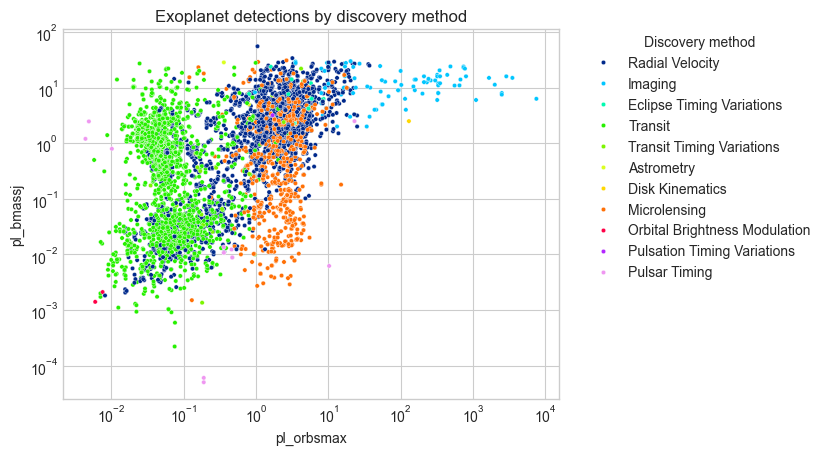

In [92]:
#create the plot
ax=sns.scatterplot(data=df2, x='pl_orbsmax', y='pl_bmassj', hue='discoverymethod', s=10, palette='gist_ncar')
plt.loglog()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Discovery method')
plt.title('Exoplanet detections by discovery method')

fig.savefig('Fig6_Discovery_methods_scatter.png')

From the above figure, we can see that the largest category by detection method is Transit (green). So we define a binary classification 'Transit' and 'Other' types of detection, adding this as a property in the df. We also need to convert any non-numerical columns into numerical values to use this data for machine learning, and remove any columns with Nan values.

In [93]:
#create transit or other property
by_transit=np.where(df2['discoverymethod']=='Transit', 1, 0)
#add as a property in the df
df2['by_transit']=by_transit

In [94]:
#convert the data type which is notfloat
notfloat=df2.columns[(df2.dtypes.values != np.dtype('float64'))]
for i in range(len(notfloat)):
    df2[notfloat[i]] = df2[notfloat[i]].astype('category').cat.codes
print(notfloat)

Index(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'sy_mnum',
       'discoverymethod', 'disc_year', 'pl_refname', 'st_refname',
       'st_spectype', 'st_metratio', 'sy_refname', 'rastr', 'decstr',
       'by_transit'],
      dtype='object')


In [95]:
#remove columns with NaN values
df2=df2.drop(columns=['pl_orbper','pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'st_teff', 'st_rad', 'st_mass', 'st_met','sy_dist'])

nan_mask = df2.isna()
print(nan_mask.sum())

pl_name            0
hostname           0
default_flag       0
sy_snum            0
sy_pnum            0
sy_mnum            0
discoverymethod    0
disc_year          0
pl_refname         0
st_refname         0
st_spectype        0
st_metratio        0
sy_refname         0
rastr              0
ra                 0
decstr             0
dec                0
by_transit         0
dtype: int64


As before, we take the first half of our dataset as training data and the second half as the test dataset.

In [96]:
#split the df into 2: training set and test set
training2 = df2.loc[: len(df2)/2]
test2 = df2.loc[len(df2)/2: ]

# output values to check df was split correctly
print(len(df2))
print(len(training2),len(test2), len(training2)+len(test2))
#print(training)
#print(test)

35921
17961 17960 35921


Next, we train the model on `training2` and predict whether the planets in `test2` could be detected by transit or alternative methods.

In [97]:
#train model
model2=GaussianNB()
model2.fit(training2, training2['by_transit']);

In [98]:
#compare predictions to test data
predicted2=model2.predict(test2)

Compare our results using a confusion matrix

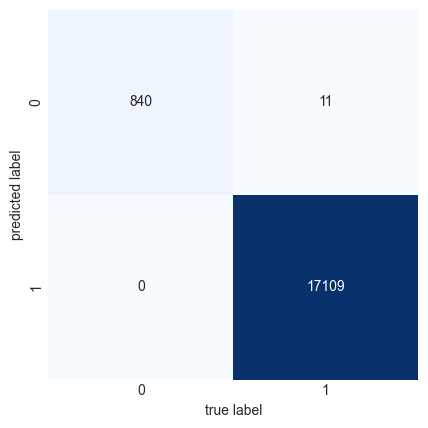

In [99]:
mat2=confusion_matrix(test2['by_transit'], predicted2)

sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

fig.savefig('Fig7_Confusion_matrix_2.png')

In [100]:
print('Correct predictions: ', mat2[0,0]+mat2[1,1])
print('Incorrect predictions: ', mat2[0,1]+mat2[1,0])

Correct predictions:  17949
Incorrect predictions:  11


We can see from the confusion matrix above that this model performs much better than the previous example, since most predictions are correct.

# References
[1] [Full lecture notes by jakevd on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Gaussian-Naive-Bayes)

[2] [NASA exoplanet archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS)
